In [1]:
#import numpy as np
from autograd.util import flatten_func
from autograd import grad as compute_grad   
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import linear_model
from sklearn.cluster import KMeans
import math
import autograd.numpy as np
import custom_utilities as util

get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
csv = open('final_project_data/final_project_point_cloud.fuse', 'r')
data=[]
num=0
for line in csv:
    ls=line.split(" ")
    data.append([float(ls[0]),float(ls[1]),float(ls[2]),float(ls[3][:-1])])
    num += 1
csv.close()
data=np.array(data)
#print(data)
print(num)
lat, long, height, i = data.T

430736


In [3]:
print(data[0])
lat0 = data[0][0]
lon0 = data[0][1]

[ 45.9038834   11.02841352 232.4648      10.        ]


In [4]:
"""
def latlontoxy(lat1, lon1, lat0,lon0):
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters
"""

'\ndef latlontoxy(lat1, lon1, lat0,lon0):\n    R = 6378.137 # Radius of earth in KM\n    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180\n    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180\n    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);\n    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));\n    d = R * c\n    return d * 1000 # meters\n'

In [5]:
def rot(x,y,co):
    cosf=1/(1+co**2)
    sinf=co/(1+co**2)
    xt=(x*cosf + y*sinf)*0.002
    yt=x*(-sinf)+y*cosf
    return xt,yt

In [6]:
def latlontoxy(lat1, lon1, lat0,lon0):
    m_per_deg_lat = 111132.954 - 559.822 * math.cos( 2.0 * lat0 ) + 1.175 * math.cos( 4.0 * lat0);
    m_per_deg_lon = (3.14159265359/180 ) * 6367449 * math.cos ( lat0 );
    x = (lat1-lat0) * m_per_deg_lat
    y = (lon1-lon0) * m_per_deg_lon
    return x,y

In [7]:
# gradient descent function
def gradient_descent(g,w,alpha,max_its,beta,version):    
    # flatten the input function, create gradient based on flat function
    g_flat, unflatten, w = flatten_func(g, w)
    grad = compute_grad(g_flat)

    # record history
    w_hist = []
    w_hist.append(unflatten(w))

    # start gradient descent loop
    z = np.zeros((np.shape(w)))      # momentum term
    
    # over the line
    for k in range(max_its):   
        # plug in value into func and derivative
        grad_eval = grad(w)
        grad_eval.shape = np.shape(w)

        ### normalized or unnormalized descent step? ###
        if version == 'normalized':
            grad_norm = np.linalg.norm(grad_eval)
            if grad_norm == 0:
                grad_norm += 10**-6*np.sign(2*np.random.rand(1) - 1)
            grad_eval /= grad_norm
            
        # take descent step with momentum
        z = beta*z + grad_eval
        w = w - alpha*z

        # record weight update
        w_hist.append(unflatten(w))

    return w_hist

In [8]:
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [9]:
model = []
for d in data:
    h = np.zeros(4)
    h[0],h[1]=latlontoxy(d[0],d[1],lat0,lon0)

    h[2]=d[2]
    h[3]=d[3]
    model.append(h)
model=np.array(model)

In [10]:
np.savetxt('b.csv',model, delimiter=' ')

In [11]:
x,y,z,i=model.T

In [12]:
#randomly select all points for the linear regression
#sample = np.array(random.sample(list(model), 4300))
sample=model
#print(np.ones(len(sample))[:, np.newaxis])
sample_pos=np.concatenate((np.ones(len(sample))[:, np.newaxis],sample[:,:-1]),axis=1)
#print(sample_pos)
sample_pos_means = np.mean(sample_pos,axis = 0)
sample_pos_stds = np.std(sample_pos,axis = 0)

sample_pos_norm = normalize(sample_pos[:,1:],sample_pos_means[1:],sample_pos_stds[1:])
sample_pos_norm = np.concatenate((np.ones(len(sample_pos))[:, np.newaxis],sample_pos_norm),axis=1)
#print(sample_pos_norm)
z_norm = sample_pos_norm[:,-1][:,np.newaxis]
#z_norm.shape(len(z_norm,1))
data_norm = sample_pos_norm[:,:-1]



In [13]:
sample_pos_norm = normalize(sample_pos[:,1:],sample_pos_means[1:],sample_pos_stds[1:])
sample_pos_norm = np.concatenate((np.ones(len(sample_pos))[:, np.newaxis],sample_pos_norm),axis=1)
#print(sample_pos_norm)
z_norm = sample_pos_norm[:,-1][:,np.newaxis]
#z_norm.shape(len(z_norm,1))
data_norm = sample_pos_norm[:,:-1]

In [14]:
w = np.random.randn(3,1)*0.01
print(w)
# least squares MSE rergession
least_squares = lambda w: np.sum((np.dot(data_norm,w) - z_norm)**2)
alpha = 10**(-3)
max_its = 2000

[[ 0.01247938]
 [-0.00776657]
 [ 0.00520171]]


In [15]:
# run gradient descent
weight_history = gradient_descent(least_squares,w,alpha,max_its,beta = 0,version = 'normalized')

# plot cost function history
cost_history = [least_squares(v) for v in weight_history]
histories = [cost_history]

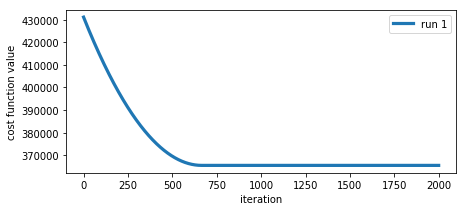

In [16]:
# plot everything
demo = util.Visualizer()
demo.compare_regression_histories(histories)

In [17]:
#print(weight_history[-1])
final_w_norm = weight_history[-1]
#threshold numbers
thresholds = (z_norm-np.dot(data_norm,final_w_norm))**2
#print(thresholds.shape)
#print(thresholds)

In [18]:
data_filtered_z = []
for d in range(len(model)):
    if thresholds[d] < 0.04:
        data_filtered_z.append(model[d])
road_data = np.array(data_filtered_z)

rx, ry, rz, ri = road_data.T

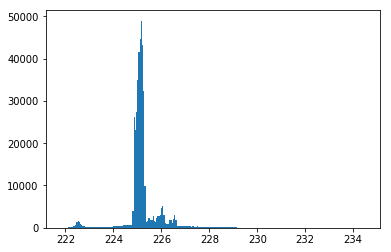

In [19]:
plt.hist(z,255)
plt.show()

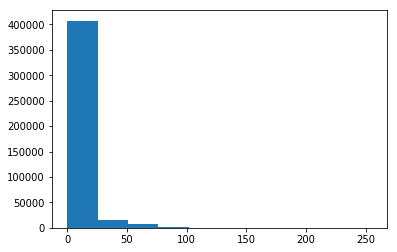

In [20]:
plt.hist(i)
plt.show()

In [21]:
'''
zrange=max(z)-min(z)
med=np.median(z)
print(med)
minimum=np.median(z)-0.005*zrange
maximum=np.median(z)+0.02*zrange
#mean=np.array(z).mean()
#std=np.array(z).std()
road_data=[ ]
k=0
for d in model:
    if d[2]>=minimum and d[2]<=maximum:
        road_data.append(d)
        k=k+1
road_data=np.array(road_data)
rx, ry, rz, ri = road_data.T
counts=plt.hist(rz, 14,color='black',alpha=0.5)
#x=[mean+2*std]*100
#x=np.array(x)
#plt.plot(x)
plt.show()
print(k)
'''

"\nzrange=max(z)-min(z)\nmed=np.median(z)\nprint(med)\nminimum=np.median(z)-0.005*zrange\nmaximum=np.median(z)+0.02*zrange\n#mean=np.array(z).mean()\n#std=np.array(z).std()\nroad_data=[ ]\nk=0\nfor d in model:\n    if d[2]>=minimum and d[2]<=maximum:\n        road_data.append(d)\n        k=k+1\nroad_data=np.array(road_data)\nrx, ry, rz, ri = road_data.T\ncounts=plt.hist(rz, 14,color='black',alpha=0.5)\n#x=[mean+2*std]*100\n#x=np.array(x)\n#plt.plot(x)\nplt.show()\nprint(k)\n"

In [22]:
np.savetxt('c.csv',road_data, delimiter=' ')

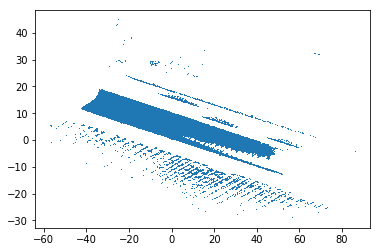

78.0 101.0


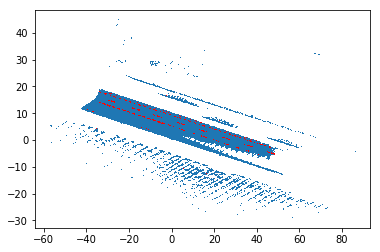

In [23]:
# draw pixel picture
fig=plt.figure()
road=fig.add_subplot(111)
road.plot(rx,ry,',')# draw pixel
plt.show()

original=[]
#intensity
si= sorted(i)[int(0.997*len(i)):int(0.9995*len(i))]
minl=min(si)
maxl=max(si)
print("{} {}".format(minl, maxl))
for e in road_data:
    if e[3]>=minl and e[3]<=maxl:
        original.append(e[:-1])
original= np.array(original)
lx, ly, lz = original.T
plt.savefig('original.png',dpi=400,bbox_inches='tight')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rx, ry, ',')
ax.plot(lx, ly, ',', color='red')
plt.savefig('lane_rough.png',dpi=400,bbox_inches='tight')
plt.show()

#bnear(e,distance=0.3) > 5

In [24]:
ox=original[:,0][:,np.newaxis]
oy=original[:,1]

model_all=linear_model.LinearRegression()
model_all.fit(ox,oy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
np.savetxt('d.csv',original, delimiter=' ')

para [-0.23157568]


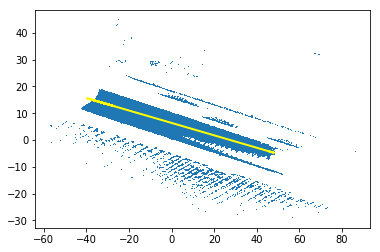

In [26]:
model_ransac_all=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_all.fit(ox,oy)
inlier_mask_all=model_ransac_all.inlier_mask_
outlier_mask_all=np.logical_not(inlier_mask_all)

linex = ox
liney = model_all.predict(ox)
alpha = model_all.coef_
print('para',alpha)
plt.plot(rx, ry, ',')
plt.plot(linex, liney, color='yellow', linestyle='-', linewidth=2, label='lane1')

In [27]:
ts=[]
for t in original:
    first,second = rot(t[0],t[1],alpha)
    ts.append([first,second])
ts=np.asarray(ts)
ts=ts.reshape(np.shape(ts)[0],2)
print(np.shape(ts))
tx,ty = ts.T

(898, 2)


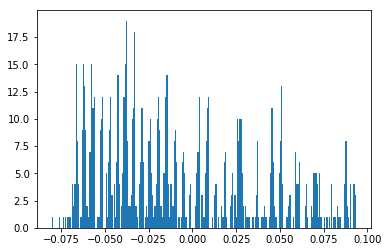

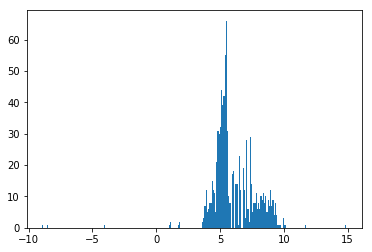

In [28]:
plt.hist(tx,255)
plt.show()
plt.hist(ty,255)
plt.show()

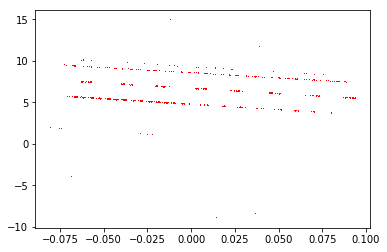

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tx, ty, ',', color='red')

(607, 1) (607,)


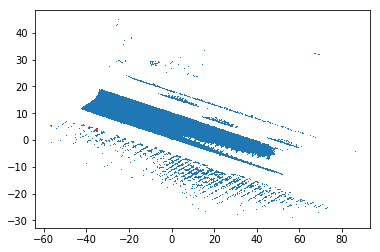

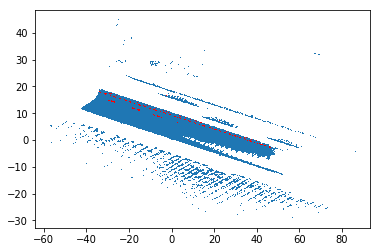

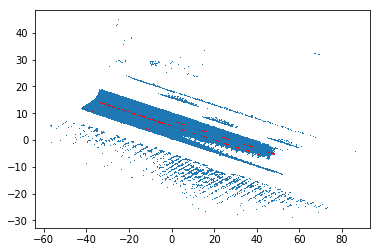

In [30]:
# In practice, the k-means algorithm is very fast (one of the fastest clustering algorithms available)
# But it falls in local minima. That’s why it can be useful to restart it several times.
iteration=1000000
# ,random_state=0
data = KMeans(max_iter=iteration,n_clusters=3).fit(ts)
label = data.labels_
lane1,lane2,lane3,lane_other,lane=[],[],[],[],[]
for q in range(len(label)):
    lane=[original[q][0],original[q][1],original[q][2]]
    if (label[q]==0):
        lane1.append(lane)
    elif (label[q]==1):
        lane2.append(lane)
    elif (label[q]==2):
        lane3.append(lane)
    else:
        lane_other.append(lane)
        
lane1=np.array(lane1)
if(len(lane1)!=0):
    x1,y1,z1=lane1.T
# print(x1.shape,x1)
X1=lane1[:,0][:,np.newaxis]
#X2=list(lane1)
Y1=lane1[:,1]
#print(X1)
#print(x1)
# x1_1=[]
# for element in x1:
#     x1_1.append(element)


lane2=np.array(lane2)

if(len(lane2)!=0):
    x2,y2,z2=lane2.T
X2=lane2[:,0][:,np.newaxis]
Y2=lane2[:,1]
lane3=np.array(lane3)

if(len(lane3)!=0):
    x3,y3,z3=lane3.T
X3=lane3[:,0][:,np.newaxis]
Y3=lane3[:,1]
print(X1.shape,Y1.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rx, ry, ',')
ax.plot(X3, Y3, ',', color='red')
plt.savefig('lane_rough.png',dpi=400,bbox_inches='tight')
plt.show()
# In[25]:

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rx, ry, ',')
ax.plot(X2, Y2, ',', color='red')
plt.savefig('lane_rough.png',dpi=400,bbox_inches='tight')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rx, ry, ',')
ax.plot(X1, Y1, ',', color='red')
plt.savefig('lane_rough.png',dpi=400,bbox_inches='tight')
plt.show()

ox=original[:,0][:,np.newaxis]
oy=original[:,1]


para [-0.23157568]


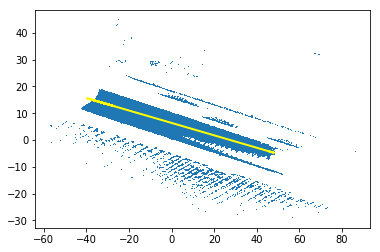

In [31]:
model_ransac_all=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_all.fit(ox,oy)
inlier_mask_all=model_ransac_all.inlier_mask_
outlier_mask_all=np.logical_not(inlier_mask_all)

linex = ox
liney = model_all.predict(ox)
alpha = model_all.coef_
print('para',alpha)
plt.plot(rx, ry, ',')
plt.plot(linex, liney, color='yellow', linestyle='-', linewidth=2, label='lane1')

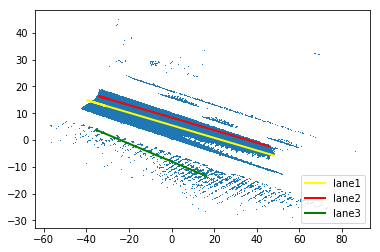

In [32]:
model=linear_model.LinearRegression()
model.fit(X1,Y1)
model2=linear_model.LinearRegression()
model3=linear_model.LinearRegression()
model2.fit(X2,Y2)
model3.fit(X3,Y3)
model_all=linear_model.LinearRegression()
model_all.fit(ox,oy)

model_ransac=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac.fit(X1,Y1)
inlier_mask=model_ransac.inlier_mask_
outlier_mask=np.logical_not(inlier_mask)

model_ransac2=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac2.fit(X2,Y2)
inlier_mask2=model_ransac2.inlier_mask_
outlier_mask2=np.logical_not(inlier_mask2)

model_ransac3=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac3.fit(X3,Y3)
inlier_mask3=model_ransac3.inlier_mask_
outlier_mask3=np.logical_not(inlier_mask3)


line_X=X1
line_y=model.predict(X1)
line_y_ransac=model_ransac.predict(X1)

line_X2=X2
line_y2=model2.predict(X2)
line_y_ransac2=model_ransac2.predict(X2)

line_X3=X3
line_y=model3.predict(X3)
line_y_ransac3=model_ransac3.predict(X3)

plt.plot(rx, ry, ',')




plt.plot(line_X, line_y_ransac, color='yellow', linestyle='-', linewidth=2, label='lane1')
plt.plot(line_X2, line_y_ransac2, color='red', linestyle='-',linewidth=2, label='lane2')
plt.plot(line_X3, line_y_ransac3, color='green', linestyle='-',linewidth=2, label='lane3')
plt.legend(loc='lower right')
plt.show()



In [33]:

"""

model_ransac_all=linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_all.fit(ox,oy)
inlier_mask_all=model_ransac_all.inlier_mask_
outlier_mask_all=np.logical_not(inlier_mask_all)

linex = ox
liney = model_all.predict(ox)
alpha = model_all.coef_
print('para',alpha)
plt.plot(rx, ry, ',')
plt.plot(linex, liney, color='yellow', linestyle='-', linewidth=2, label='lane1')

"""

"\n\nmodel_ransac_all=linear_model.RANSACRegressor(linear_model.LinearRegression())\nmodel_ransac_all.fit(ox,oy)\ninlier_mask_all=model_ransac_all.inlier_mask_\noutlier_mask_all=np.logical_not(inlier_mask_all)\n\nlinex = ox\nliney = model_all.predict(ox)\nalpha = model_all.coef_\nprint('para',alpha)\nplt.plot(rx, ry, ',')\nplt.plot(linex, liney, color='yellow', linestyle='-', linewidth=2, label='lane1')\n\n"